In [4]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls /content/gdrive/Othercomputers/'My Computer'/IFT6135_W25_A2_release/

 checkpointing.py	      'main_model_scaling_part 2.ipynb'   __pycache__
 data.py		       main_modulo.ipynb		  README.md
 gpt.py			       main_regularization.ipynb	  requirements.txt
 lstm.py		       main_sanity_check.ipynb		  run_exp.py
 main_base_trianing.ipynb      main_scaling_compute.ipynb	  trainer.py
 main_data_scaling.ipynb       plots				  train.py
 main_interpretability.ipynb   plotter.py			  Upload
 main_model_scaling.ipynb      proccess.py


In [6]:
!ls /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release/logs

0   11	14  17	2   22	25  28	30  33	36  39	41  44	47  5	6  9	 wd_0.25  wd_1.0
1   12	15  18	20  23	26  29	31  34	37  4	42  45	48  50	7  gpt	 wd_0.5
10  13	16  19	21  24	27  3	32  35	38  40	43  46	49  51	8  lstm  wd_0.75


In [ ]:
!ls /content/

gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release

/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [ ]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release


In [ ]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/'Colab Notebooks'/IFT6135_W25_A2_release" #@param {type:"string"}
!ln -Ts "$folder" /content/assignment 2> /dev/null

# Add the assignment folder to Python path
if '/content/assignment' not in sys.path:
  sys.path.insert(0, '/content/assignment')

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [ ]:
%matplotlib inline
import warnings

from dataclasses import dataclass
import torch
from torch import optim

import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
import time
import os


In [3]:
!ls /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/lstm/layer_2/b=256'

/bin/bash: line 1: ls /content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/lstm/layer_2/b=256: No such file or directory


# LSTM

In [7]:
import torch

file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/lstm/layer_1/b=64/0/B=64.pth"

# Load the dictionary
data = torch.load(file_path, map_location=torch.device('cpu'))

# Print all top-level keys
print("Top-level keys in the dictionary:")
print("-" * 30)
for key in data.keys():
    print(key)

# If you want to check nested keys (e.g., inside 'train' or 'test')
if 'train' in data:
    print("\nKeys inside 'train':")
    print("-" * 30)
    for key in data['train'].keys():
        print(key)

if 'test' in data:
    print("\nKeys inside 'test':")
    print("-" * 30)
    for key in data['test'].keys():
        print(key)

Top-level keys in the dictionary:
------------------------------
train
test
steps_epoch
all_steps

Keys inside 'train':
------------------------------
loss
accuracy

Keys inside 'test':
------------------------------
loss
accuracy


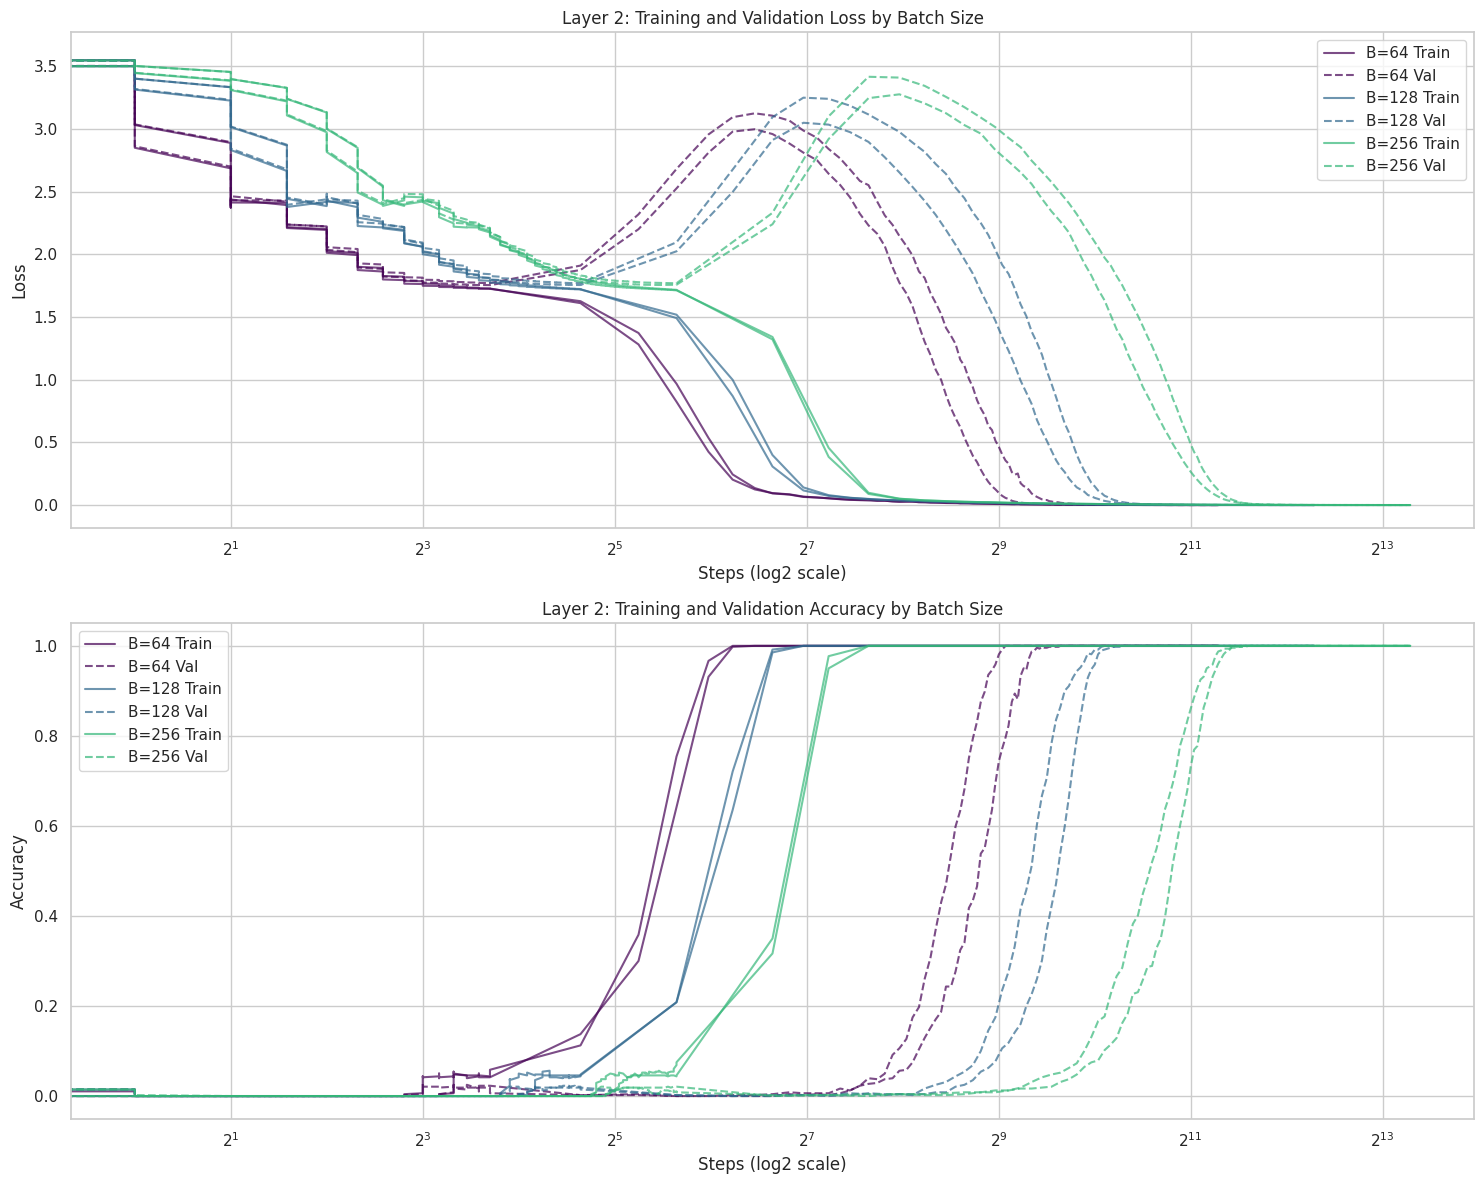


Summary Metrics for Layer 2 (Averaged across runs):
 Layer  Batch_Size  Run  Min_Train_Loss  Min_Val_Loss  Max_Train_Acc  Max_Val_Acc  Steps_To_Min_Train_Loss  Steps_To_Min_Val_Loss  Steps_To_Max_Train_Acc  Steps_To_Max_Val_Acc
     2          64  1.5        0.000005      0.000013            1.0          1.0                   2501.0                 2500.5                    81.5                 669.0
     2         128  1.5        0.000003      0.000006            1.0          1.0                   5000.5                 5001.0                   125.0                1175.0
     2         256  1.5        0.000001      0.000005            1.0          1.0                  10000.5                10001.0                   200.0                3050.0

Minimum Loss by Batch Size:
Batch_Size           64        128       256
Min_Train_Loss  0.000005  0.000003  0.000001
Min_Val_Loss    0.000013  0.000006  0.000005

Maximum Accuracy by Batch Size:
Batch_Size     64   128  256
Max_Train_Acc  1.

In [12]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [15, 10]

# Base directory containing the logs
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/lstm"

# Configuration parameters
layer = 2  # Only process layer 2
batch_sizes = [64, 128, 256]  # 2^6=64, 2^7=128, 2^8=256

# Initialize dictionaries to store paths and metrics
file_paths = defaultdict(list)
raw_metrics = defaultdict(dict)
summary_metrics = []

def to_np(x):
    """Convert torch.Tensors or lists to numpy arrays"""
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

# Collect all the log file paths for layer 2
for b in batch_sizes:
    # Construct the path pattern
    dir_path = os.path.join(base_dir, f"layer_{layer}", f"b={b}")

    # Find all subdirectories (like '0/', '1/', etc.)
    try:
        subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
    except FileNotFoundError:
        print(f"Directory not found: {dir_path}")
        continue

    for subdir in subdirs:
        # Try multiple possible filename patterns
        possible_files = [
            os.path.join(dir_path, subdir, f"B={b}.pth"),
            os.path.join(dir_path, subdir, f"B={b}_L={layer}.pth"),
            os.path.join(dir_path, subdir, f"b={b}.pth")
        ]

        for file_path in possible_files:
            if os.path.exists(file_path):
                file_paths[b].append(file_path)
                break  # Use the first valid file found

# Extract metrics for all found files
for b in batch_sizes:
    for path_idx, path in enumerate(file_paths[b]):
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            # Verify the expected keys are present
            if not all(k in data for k in ['train', 'test', 'steps_epoch']):
                print(f"Unexpected data format in {path}")
                continue

            # Convert all metrics to numpy arrays
            train_loss = to_np(data['train']['loss'])
            val_loss = to_np(data['test']['loss'])
            train_acc = to_np(data['train']['accuracy'])
            val_acc = to_np(data['test']['accuracy'])
            steps = to_np(list(data['steps_epoch'].values()))

            # Make sure we don't have more steps than data points
            min_len = min(len(train_loss), len(val_loss), len(train_acc), len(val_acc), len(steps))
            train_loss = train_loss[:min_len]
            val_loss = val_loss[:min_len]
            train_acc = train_acc[:min_len]
            val_acc = val_acc[:min_len]
            steps = steps[:min_len]

            # Store raw metrics for plotting
            key = (b, path_idx)
            raw_metrics[key] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'steps': steps
            }

            # Find minimum loss and corresponding step
            train_min_loss_idx = np.argmin(train_loss)
            val_min_loss_idx = np.argmin(val_loss)

            # Find maximum accuracy and corresponding step
            train_max_acc_idx = np.argmax(train_acc)
            val_max_acc_idx = np.argmax(val_acc)

            # Collect summary metrics
            run_metrics = {
                'Layer': layer,
                'Batch_Size': b,
                'Run': path_idx + 1,
                'Min_Train_Loss': train_loss[train_min_loss_idx],
                'Min_Val_Loss': val_loss[val_min_loss_idx],
                'Max_Train_Acc': train_acc[train_max_acc_idx],
                'Max_Val_Acc': val_acc[val_max_acc_idx],
                'Steps_To_Min_Train_Loss': steps[train_min_loss_idx],
                'Steps_To_Min_Val_Loss': steps[val_min_loss_idx],
                'Steps_To_Max_Train_Acc': steps[train_max_acc_idx],
                'Steps_To_Max_Val_Acc': steps[val_max_acc_idx]
            }
            summary_metrics.append(run_metrics)

        except Exception as e:
            print(f"Error processing {path}: {e}")

# =============================================
# PLOTTING CODE FOR LAYER 2
# =============================================

def plot_metrics():
    """Plot training/validation curves for layer 2"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # Plot Loss curves
    for b in batch_sizes:
        for run_idx in range(len(file_paths[b])):
            key = (b, run_idx)
            if key in raw_metrics:
                metrics = raw_metrics[key]
                steps = metrics['steps']

                # Plot training loss
                ax1.plot(steps, metrics['train_loss'],
                        linestyle='-', alpha=0.7,
                        label=f'B={b} Train' if run_idx == 0 else "",
                        color=plt.cm.viridis(batch_sizes.index(b)/len(batch_sizes)))
                # Plot validation loss
                ax1.plot(steps, metrics['val_loss'],
                        linestyle='--', alpha=0.7,
                        label=f'B={b} Val' if run_idx == 0 else "",
                        color=plt.cm.viridis(batch_sizes.index(b)/len(batch_sizes)))

    ax1.set_xscale('log', base=2)
    ax1.set_xlabel('Steps (log2 scale)')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Layer {layer}: Training and Validation Loss by Batch Size')
    ax1.legend()

    # Plot Accuracy curves
    for b in batch_sizes:
        for run_idx in range(len(file_paths[b])):
            key = (b, run_idx)
            if key in raw_metrics:
                metrics = raw_metrics[key]
                steps = metrics['steps']

                # Plot training accuracy
                ax2.plot(steps, metrics['train_acc'],
                         linestyle='-', alpha=0.7,
                         label=f'B={b} Train' if run_idx == 0 else "",
                         color=plt.cm.viridis(batch_sizes.index(b)/len(batch_sizes)))
                # Plot validation accuracy
                ax2.plot(steps, metrics['val_acc'],
                         linestyle='--', alpha=0.7,
                         label=f'B={b} Val' if run_idx == 0 else "",
                         color=plt.cm.viridis(batch_sizes.index(b)/len(batch_sizes)))

    ax2.set_xscale('log', base=2)
    ax2.set_xlabel('Steps (log2 scale)')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'Layer {layer}: Training and Validation Accuracy by Batch Size')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Generate plots
plot_metrics()

# =============================================
# SUMMARY STATISTICS FOR LAYER 2
# =============================================

# Convert to DataFrame
metrics_df = pd.DataFrame(summary_metrics)

# Calculate average metrics across runs for each batch size
avg_metrics = metrics_df.groupby(['Layer', 'Batch_Size']).mean().reset_index()

# Print summary table
print("\nSummary Metrics for Layer 2 (Averaged across runs):")
print(avg_metrics.to_string(index=False))

# Create pivot tables
print("\nMinimum Loss by Batch Size:")
print(pd.pivot_table(avg_metrics,
                    values=['Min_Train_Loss', 'Min_Val_Loss'],
                    columns='Batch_Size'))

print("\nMaximum Accuracy by Batch Size:")
print(pd.pivot_table(avg_metrics,
                    values=['Max_Train_Acc', 'Max_Val_Acc'],
                    columns='Batch_Size'))

<ipython-input-62-9a60bde895ef>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


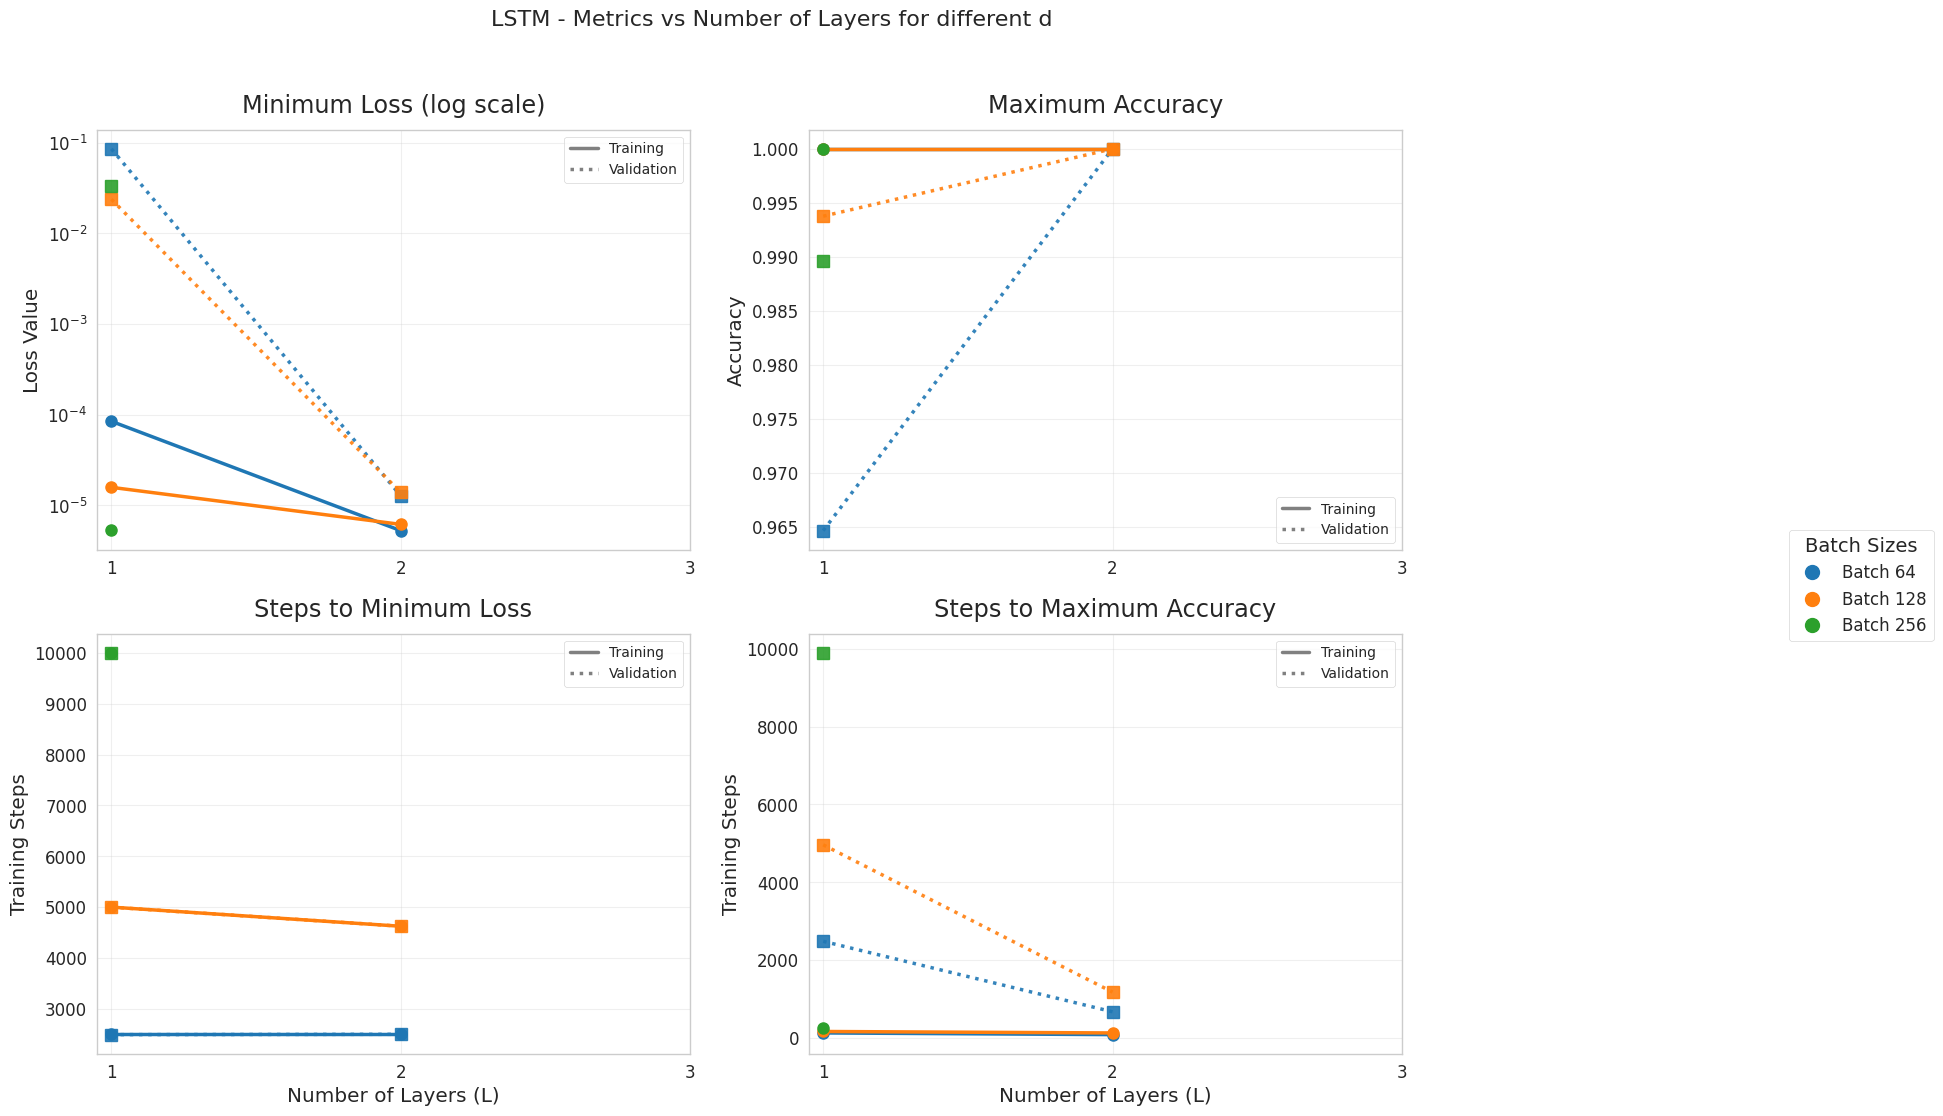

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_metrics_vs_layers(avg_metrics):
    # Create figure with 4 subplots (2x2 grid)
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1],
                         right=0.85)  # Make space for legend

    ax1 = fig.add_subplot(gs[0, 0])  # Loss plot
    ax2 = fig.add_subplot(gs[0, 1])  # Accuracy plot
    ax3 = fig.add_subplot(gs[1, 0])  # Steps to min loss
    ax4 = fig.add_subplot(gs[1, 1])  # Steps to max acc

    fig.suptitle('LSTM - Metrics vs Number of Layers for different d', fontsize=16, y=0.98)

    # Define batch size colors and styles
    batch_colors = {64: '#1f77b4', 128: '#ff7f0e', 256: '#2ca02c'}
    train_style = '-'  # Solid line for training
    val_style = ':'    # Dotted line for validation

    # ===========================================
    # 1. Minimum Loss Plot (log scale)
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training loss
        ax1.plot(subset['Layer'], subset['Min_Train_Loss'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation loss
        ax1.plot(subset['Layer'], subset['Min_Val_Loss'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax1.set_yscale('log')
    ax1.set_title('Minimum Loss (log scale)', pad=12)
    ax1.set_ylabel('Loss Value')
    ax1.set_xticks(layers)
    ax1.grid(True, alpha=0.3)

    # Add local legend for line styles
    style_legend = [
        plt.Line2D([0], [0], color='gray', linestyle=train_style, linewidth=2.5, label='Training'),
        plt.Line2D([0], [0], color='gray', linestyle=val_style, linewidth=2.5, label='Validation')
    ]
    ax1.legend(handles=style_legend, loc='upper right', fontsize=10)

    # ===========================================
    # 2. Maximum Accuracy Plot
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training accuracy
        ax2.plot(subset['Layer'], subset['Max_Train_Acc'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation accuracy
        ax2.plot(subset['Layer'], subset['Max_Val_Acc'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax2.set_title('Maximum Accuracy', pad=12)
    ax2.set_ylabel('Accuracy')
    ax2.set_xticks(layers)
    ax2.grid(True, alpha=0.3)
    ax2.legend(handles=style_legend, loc='lower right', fontsize=10)

    # ===========================================
    # 3. Steps to Minimum Loss
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training steps
        ax3.plot(subset['Layer'], subset['Steps_To_Min_Train_Loss'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation steps
        ax3.plot(subset['Layer'], subset['Steps_To_Min_Val_Loss'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax3.set_title('Steps to Minimum Loss', pad=12)
    ax3.set_xlabel('Number of Layers (L)')
    ax3.set_ylabel('Training Steps')
    ax3.set_xticks(layers)
    ax3.grid(True, alpha=0.3)
    ax3.legend(handles=style_legend, loc='upper right', fontsize=10)

    # ===========================================
    # 4. Steps to Maximum Accuracy
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training steps
        ax4.plot(subset['Layer'], subset['Steps_To_Max_Train_Acc'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation steps
        ax4.plot(subset['Layer'], subset['Steps_To_Max_Val_Acc'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax4.set_title('Steps to Maximum Accuracy', pad=12)
    ax4.set_xlabel('Number of Layers (L)')
    ax4.set_ylabel('Training Steps')
    ax4.set_xticks(layers)
    ax4.grid(True, alpha=0.3)
    ax4.legend(handles=style_legend, loc='upper right', fontsize=10)

    # ===========================================
    # Create the main batch size legend
    # ===========================================
    batch_legend = [
        plt.Line2D([0], [0], color=batch_colors[b], marker='o', linestyle='None',
                  markersize=10, label=f'Batch {b}') for b in batch_sizes
    ]

    # Add the legend outside the plot area
    fig.legend(handles=batch_legend, title='Batch Sizes',
              loc='center right', bbox_to_anchor=(1.15, 0.5),
              fontsize=12, title_fontsize=14)

    plt.tight_layout()
    plt.show()

# Generate the plot
plot_metrics_vs_layers(avg_metrics)

# GPT

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

# Base directory containing the logs
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/gpt"

# Configuration parameters
layers = [1, 2, 3]  # Process all layers
batch_sizes = [64, 128, 256]  # 2^6=64, 2^7=128, 2^8=256

# Initialize dictionaries to store paths and metrics
file_paths = defaultdict(list)
raw_metrics = defaultdict(dict)
summary_metrics = []

def to_np(x):
    """Convert torch.Tensors or lists to numpy arrays"""
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

# Collect all the log file paths
for layer in layers:
    for b in batch_sizes:
        # Construct the path pattern
        dir_path = os.path.join(base_dir, f"layer_{layer}", f"b={b}")

        # Find all subdirectories (like '0/', '1/', etc.)
        try:
            subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        except FileNotFoundError:
            print(f"Directory not found: {dir_path}")
            continue

        for subdir in subdirs:
            # Try multiple possible filename patterns
            possible_files = [
                os.path.join(dir_path, subdir, f"B={b}.pth"),
                os.path.join(dir_path, subdir, f"B={b}_L={layer}.pth"),
                os.path.join(dir_path, subdir, f"b={b}.pth")
            ]

            for file_path in possible_files:
                if os.path.exists(file_path):
                    key = (layer, b)
                    file_paths[key].append(file_path)
                    break  # Use the first valid file found

# Extract metrics for all found files
for (layer, b), paths in file_paths.items():
    for path_idx, path in enumerate(paths):
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            # Verify the expected keys are present
            if not all(k in data for k in ['train', 'test', 'steps_epoch']):
                print(f"Unexpected data format in {path}")
                continue

            # Convert all metrics to numpy arrays
            train_loss = to_np(data['train']['loss'])
            val_loss = to_np(data['test']['loss'])
            train_acc = to_np(data['train']['accuracy'])
            val_acc = to_np(data['test']['accuracy'])
            steps = to_np(list(data['steps_epoch'].values()))

            # Make sure we don't have more steps than data points
            min_len = min(len(train_loss), len(val_loss), len(train_acc), len(val_acc), len(steps))
            train_loss = train_loss[:min_len]
            val_loss = val_loss[:min_len]
            train_acc = train_acc[:min_len]
            val_acc = val_acc[:min_len]
            steps = steps[:min_len]

            # Find minimum loss and corresponding step
            train_min_loss_idx = np.argmin(train_loss)
            val_min_loss_idx = np.argmin(val_loss)

            # Find maximum accuracy and corresponding step
            train_max_acc_idx = np.argmax(train_acc)
            val_max_acc_idx = np.argmax(val_acc)

            # Collect metrics in a structured format
            run_metrics = {
                'Layer': layer,
                'Batch_Size': b,
                'Run': path_idx + 1,

                # Minimum loss values
                'Min_Train_Loss': train_loss[train_min_loss_idx],
                'Min_Val_Loss': val_loss[val_min_loss_idx],

                # Maximum accuracy values
                'Max_Train_Acc': train_acc[train_max_acc_idx],
                'Max_Val_Acc': val_acc[val_max_acc_idx],

                # Steps to reach optimal values
                'Steps_To_Min_Train_Loss': steps[train_min_loss_idx],
                'Steps_To_Min_Val_Loss': steps[val_min_loss_idx],
                'Steps_To_Max_Train_Acc': steps[train_max_acc_idx],
                'Steps_To_Max_Val_Acc': steps[val_max_acc_idx]
            }

            summary_metrics.append(run_metrics)

            # Store raw metrics for possible further analysis
            key = (layer, b, path_idx)
            raw_metrics[key] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'steps': steps
            }

        except Exception as e:
            print(f"Error processing {path}: {e}")

# Convert to DataFrame for easier analysis
metrics_df = pd.DataFrame(summary_metrics)

# Calculate average metrics across runs for each layer and batch size
avg_metrics = metrics_df.groupby(['Layer', 'Batch_Size']).mean().reset_index()

# Print summary table
print("\nSummary Metrics by Layer and Batch Size (Averaged across runs):")
print(avg_metrics.to_string(index=False))

# Export to CSV if needed
avg_metrics.to_csv('lstm_metrics_summary.csv', index=False)

# Create a pivot table for easier comparison
pivot_min_loss = pd.pivot_table(
    avg_metrics,
    values=['Min_Train_Loss', 'Min_Val_Loss'],
    index='Layer',
    columns='Batch_Size'
)

pivot_max_acc = pd.pivot_table(
    avg_metrics,
    values=['Max_Train_Acc', 'Max_Val_Acc'],
    index='Layer',
    columns='Batch_Size'
)

pivot_time_to_min_loss = pd.pivot_table(
    avg_metrics,
    values=['Steps_To_Min_Train_Loss', 'Steps_To_Min_Val_Loss'],
    index='Layer',
    columns='Batch_Size'
)

pivot_time_to_max_acc = pd.pivot_table(
    avg_metrics,
    values=['Steps_To_Max_Train_Acc', 'Steps_To_Max_Val_Acc'],
    index='Layer',
    columns='Batch_Size'
)

print("\nMinimum Loss (Layer vs Batch Size):")
print(pivot_min_loss)

print("\nMaximum Accuracy (Layer vs Batch Size):")
print(pivot_max_acc)

print("\nSteps to Minimum Loss (Layer vs Batch Size):")
print(pivot_time_to_min_loss)

print("\nSteps to Maximum Accuracy (Layer vs Batch Size):")
print(pivot_time_to_max_acc)


Summary Metrics by Layer and Batch Size (Averaged across runs):
 Layer  Batch_Size  Run  Min_Train_Loss  Min_Val_Loss  Max_Train_Acc  Max_Val_Acc  Steps_To_Min_Train_Loss  Steps_To_Min_Val_Loss  Steps_To_Max_Train_Acc  Steps_To_Max_Val_Acc
     1          64  1.5        0.000618      0.001161            1.0     1.000000                   2181.5                 1900.5                    75.5                 800.5
     1         128  1.5        0.000430      0.001178            1.0     1.000000                   3937.5                 3650.0                   125.0                2450.0
     1         256  1.5        0.000322      0.155345            1.0     0.905405                   7600.0                 8375.5                   225.0                7925.0
     2          64  1.5        0.002031      0.004116            1.0     1.000000                   1350.5                 1863.0                    31.5                 975.0
     2         128  1.5        0.000202      0.001056  

<ipython-input-30-ac9bcbfd5f00>:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


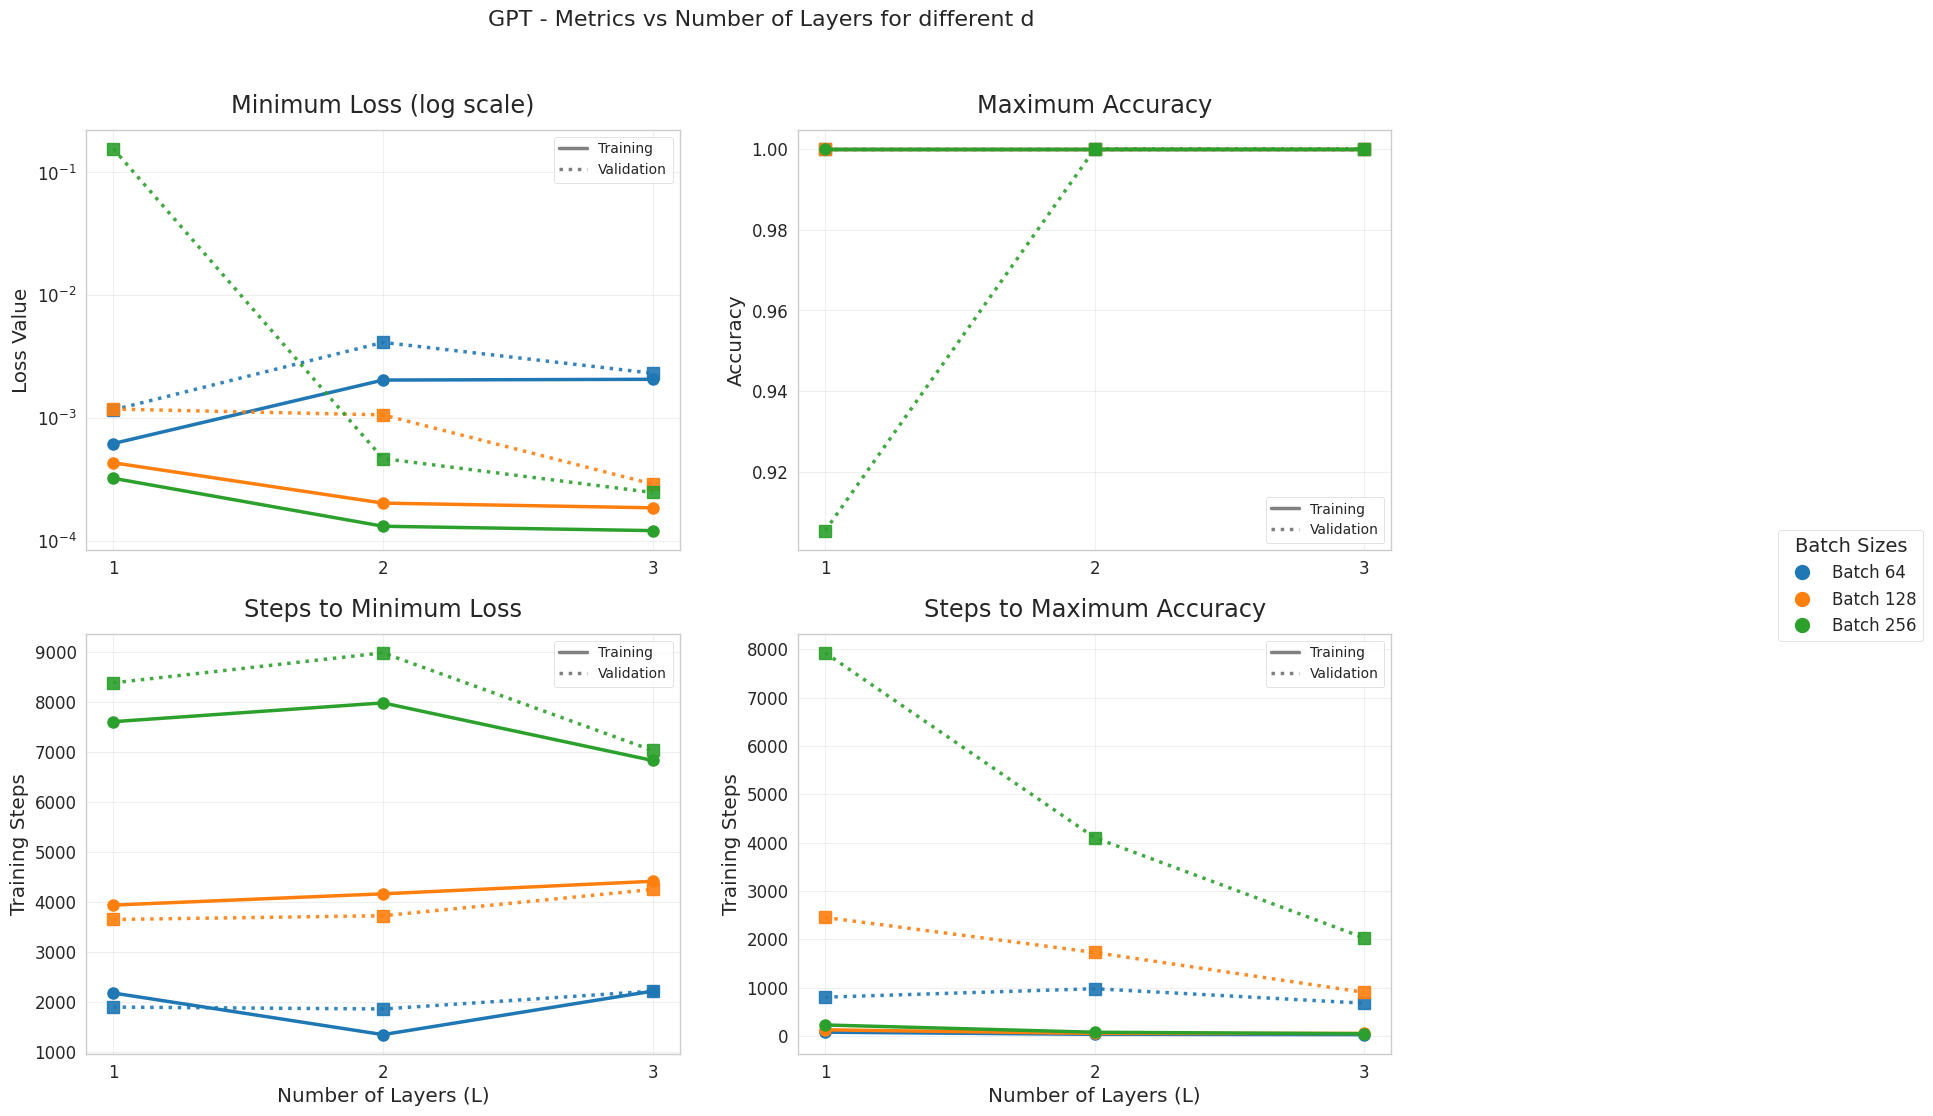

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_metrics_vs_layers(avg_metrics):
    # Create figure with 4 subplots (2x2 grid)
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1],
                         right=0.85)  # Make space for legend

    ax1 = fig.add_subplot(gs[0, 0])  # Loss plot
    ax2 = fig.add_subplot(gs[0, 1])  # Accuracy plot
    ax3 = fig.add_subplot(gs[1, 0])  # Steps to min loss
    ax4 = fig.add_subplot(gs[1, 1])  # Steps to max acc

    fig.suptitle('GPT - Metrics vs Number of Layers for different d', fontsize=16, y=0.98)

    # Define batch size colors and styles
    batch_colors = {64: '#1f77b4', 128: '#ff7f0e', 256: '#2ca02c'}
    train_style = '-'  # Solid line for training
    val_style = ':'    # Dotted line for validation

    # ===========================================
    # 1. Minimum Loss Plot (log scale)
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training loss
        ax1.plot(subset['Layer'], subset['Min_Train_Loss'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation loss
        ax1.plot(subset['Layer'], subset['Min_Val_Loss'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax1.set_yscale('log')
    ax1.set_title('Minimum Loss (log scale)', pad=12)
    ax1.set_ylabel('Loss Value')
    ax1.set_xticks(layers)
    ax1.grid(True, alpha=0.3)

    # Add local legend for line styles
    style_legend = [
        plt.Line2D([0], [0], color='gray', linestyle=train_style, linewidth=2.5, label='Training'),
        plt.Line2D([0], [0], color='gray', linestyle=val_style, linewidth=2.5, label='Validation')
    ]
    ax1.legend(handles=style_legend, loc='upper right', fontsize=10)

    # ===========================================
    # 2. Maximum Accuracy Plot
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training accuracy
        ax2.plot(subset['Layer'], subset['Max_Train_Acc'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation accuracy
        ax2.plot(subset['Layer'], subset['Max_Val_Acc'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax2.set_title('Maximum Accuracy', pad=12)
    ax2.set_ylabel('Accuracy')
    ax2.set_xticks(layers)
    ax2.grid(True, alpha=0.3)
    ax2.legend(handles=style_legend, loc='lower right', fontsize=10)

    # ===========================================
    # 3. Steps to Minimum Loss
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training steps
        ax3.plot(subset['Layer'], subset['Steps_To_Min_Train_Loss'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation steps
        ax3.plot(subset['Layer'], subset['Steps_To_Min_Val_Loss'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax3.set_title('Steps to Minimum Loss', pad=12)
    ax3.set_xlabel('Number of Layers (L)')
    ax3.set_ylabel('Training Steps')
    ax3.set_xticks(layers)
    ax3.grid(True, alpha=0.3)
    ax3.legend(handles=style_legend, loc='upper right', fontsize=10)

    # ===========================================
    # 4. Steps to Maximum Accuracy
    # ===========================================
    for b in batch_sizes:
        subset = avg_metrics[avg_metrics['Batch_Size'] == b]
        # Training steps
        ax4.plot(subset['Layer'], subset['Steps_To_Max_Train_Acc'],
                marker='o', linestyle=train_style, color=batch_colors[b],
                linewidth=2.5, markersize=8)
        # Validation steps
        ax4.plot(subset['Layer'], subset['Steps_To_Max_Val_Acc'],
                marker='s', linestyle=val_style, color=batch_colors[b],
                linewidth=2.5, markersize=8, alpha=0.9)

    ax4.set_title('Steps to Maximum Accuracy', pad=12)
    ax4.set_xlabel('Number of Layers (L)')
    ax4.set_ylabel('Training Steps')
    ax4.set_xticks(layers)
    ax4.grid(True, alpha=0.3)
    ax4.legend(handles=style_legend, loc='upper right', fontsize=10)

    # ===========================================
    # Create the main batch size legend
    # ===========================================
    batch_legend = [
        plt.Line2D([0], [0], color=batch_colors[b], marker='o', linestyle='None',
                  markersize=10, label=f'Batch {b}') for b in batch_sizes
    ]

    # Add the legend outside the plot area
    fig.legend(handles=batch_legend, title='Batch Sizes',
              loc='center right', bbox_to_anchor=(1.15, 0.5),
              fontsize=12, title_fontsize=14)

    plt.tight_layout()
    plt.show()

# Generate the plot
plot_metrics_vs_layers(avg_metrics)

#Params

## LSTM

In [ ]:
file_path = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/lstm/layer_1/b=64/0/num_param.txt"

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path

# Helper function to convert tensors/lists to numpy arrays
def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

# Function to read number of parameters from a text file
def read_num_params(file_path):
    try:
        with open(file_path, 'r') as f:
            content = f.read().strip()
            if "parameters" in content.lower():
                return int(content.split(":")[-1].strip())
            else:
                return int(content)
    except Exception:
        return None

# Load metrics and parameter values from a base log directory
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/lstm"
layers = [1, 2, 3]
batch_sizes = [64, 128, 256]

file_paths = defaultdict(list)
param_file_paths = defaultdict(list)
raw_metrics = defaultdict(dict)
summary_metrics = []

# Collect file paths
for layer in layers:
    for b in batch_sizes:
        dir_path = os.path.join(base_dir, f"layer_{layer}", f"b={b}")
        try:
            subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        except FileNotFoundError:
            continue

        for subdir in subdirs:
            possible_files = [
                os.path.join(dir_path, subdir, f"B={b}.pth"),
                os.path.join(dir_path, subdir, f"B={b}_L={layer}.pth"),
                os.path.join(dir_path, subdir, f"b={b}.pth")
            ]
            param_file = os.path.join(dir_path, subdir, "num_params.txt")

            for file_path in possible_files:
                if os.path.exists(file_path):
                    key = (layer, b)
                    file_paths[key].append(file_path)
                    param_file_paths[key].append(param_file if os.path.exists(param_file) else None)
                    break

# Extract metrics
for (layer, b), paths in file_paths.items():
    param_paths = param_file_paths.get((layer, b), [None] * len(paths))

    for path_idx, (path, param_path) in enumerate(zip(paths, param_paths)):
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            if not all(k in data for k in ['train', 'test', 'steps_epoch']):
                continue

            train_loss = to_np(data['train']['loss'])
            val_loss = to_np(data['test']['loss'])
            train_acc = to_np(data['train']['accuracy'])
            val_acc = to_np(data['test']['accuracy'])
            steps = to_np(list(data['steps_epoch'].values()))

            min_len = min(len(train_loss), len(val_loss), len(train_acc), len(val_acc), len(steps))
            train_loss = train_loss[:min_len]
            val_loss = val_loss[:min_len]
            train_acc = train_acc[:min_len]
            val_acc = val_acc[:min_len]
            steps = steps[:min_len]

            train_min_loss_idx = np.argmin(train_loss)
            val_min_loss_idx = np.argmin(val_loss)
            train_max_acc_idx = np.argmax(train_acc)
            val_max_acc_idx = np.argmax(val_acc)

            num_params = read_num_params(param_path) if param_path else None

            run_metrics = {
                'Layer': layer,
                'Batch_Size': b,
                'Run': path_idx + 1,
                'Num_Parameters': num_params,
                'Min_Train_Loss': train_loss[train_min_loss_idx],
                'Min_Val_Loss': val_loss[val_min_loss_idx],
                'Max_Train_Acc': train_acc[train_max_acc_idx],
                'Max_Val_Acc': val_acc[val_max_acc_idx],
                'Steps_To_Min_Train_Loss': steps[train_min_loss_idx],
                'Steps_To_Min_Val_Loss': steps[val_min_loss_idx],
                'Steps_To_Max_Train_Acc': steps[train_max_acc_idx],
                'Steps_To_Max_Val_Acc': steps[val_max_acc_idx]
            }

            summary_metrics.append(run_metrics)
            raw_metrics[(layer, b, path_idx)] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'steps': steps,
                'num_params': num_params
            }

        except Exception:
            continue

# Build DataFrame
metrics_df = pd.DataFrame(summary_metrics)
avg_metrics = metrics_df.groupby(['Layer', 'Batch_Size']).mean(numeric_only=True).reset_index()

# Generate pivot tables
pivot_params = pd.pivot_table(metrics_df, values='Num_Parameters', index='Layer', columns='Batch_Size', aggfunc='mean')
pivot_min_loss = pd.pivot_table(avg_metrics, values=['Min_Train_Loss', 'Min_Val_Loss'], index='Layer', columns='Batch_Size')
pivot_max_acc = pd.pivot_table(avg_metrics, values=['Max_Train_Acc', 'Max_Val_Acc'], index='Layer', columns='Batch_Size')
pivot_time_to_min_loss = pd.pivot_table(avg_metrics, values=['Steps_To_Min_Train_Loss', 'Steps_To_Min_Val_Loss'], index='Layer', columns='Batch_Size')
pivot_time_to_max_acc = pd.pivot_table(avg_metrics, values=['Steps_To_Max_Train_Acc', 'Steps_To_Max_Val_Acc'], index='Layer', columns='Batch_Size')

# Export CSVs
metrics_df.to_csv('lstm_metrics_detailed.csv', index=False)
avg_metrics.to_csv('lstm_metrics_summary.csv', index=False)

# Return DataFrames to user
import ace_tools as tools; tools.display_dataframe_to_user(name="LSTM Summary Metrics", dataframe=avg_metrics)


KeyError: 'Layer'

<ipython-input-10-f46e329afd92>:94: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Layer Count')


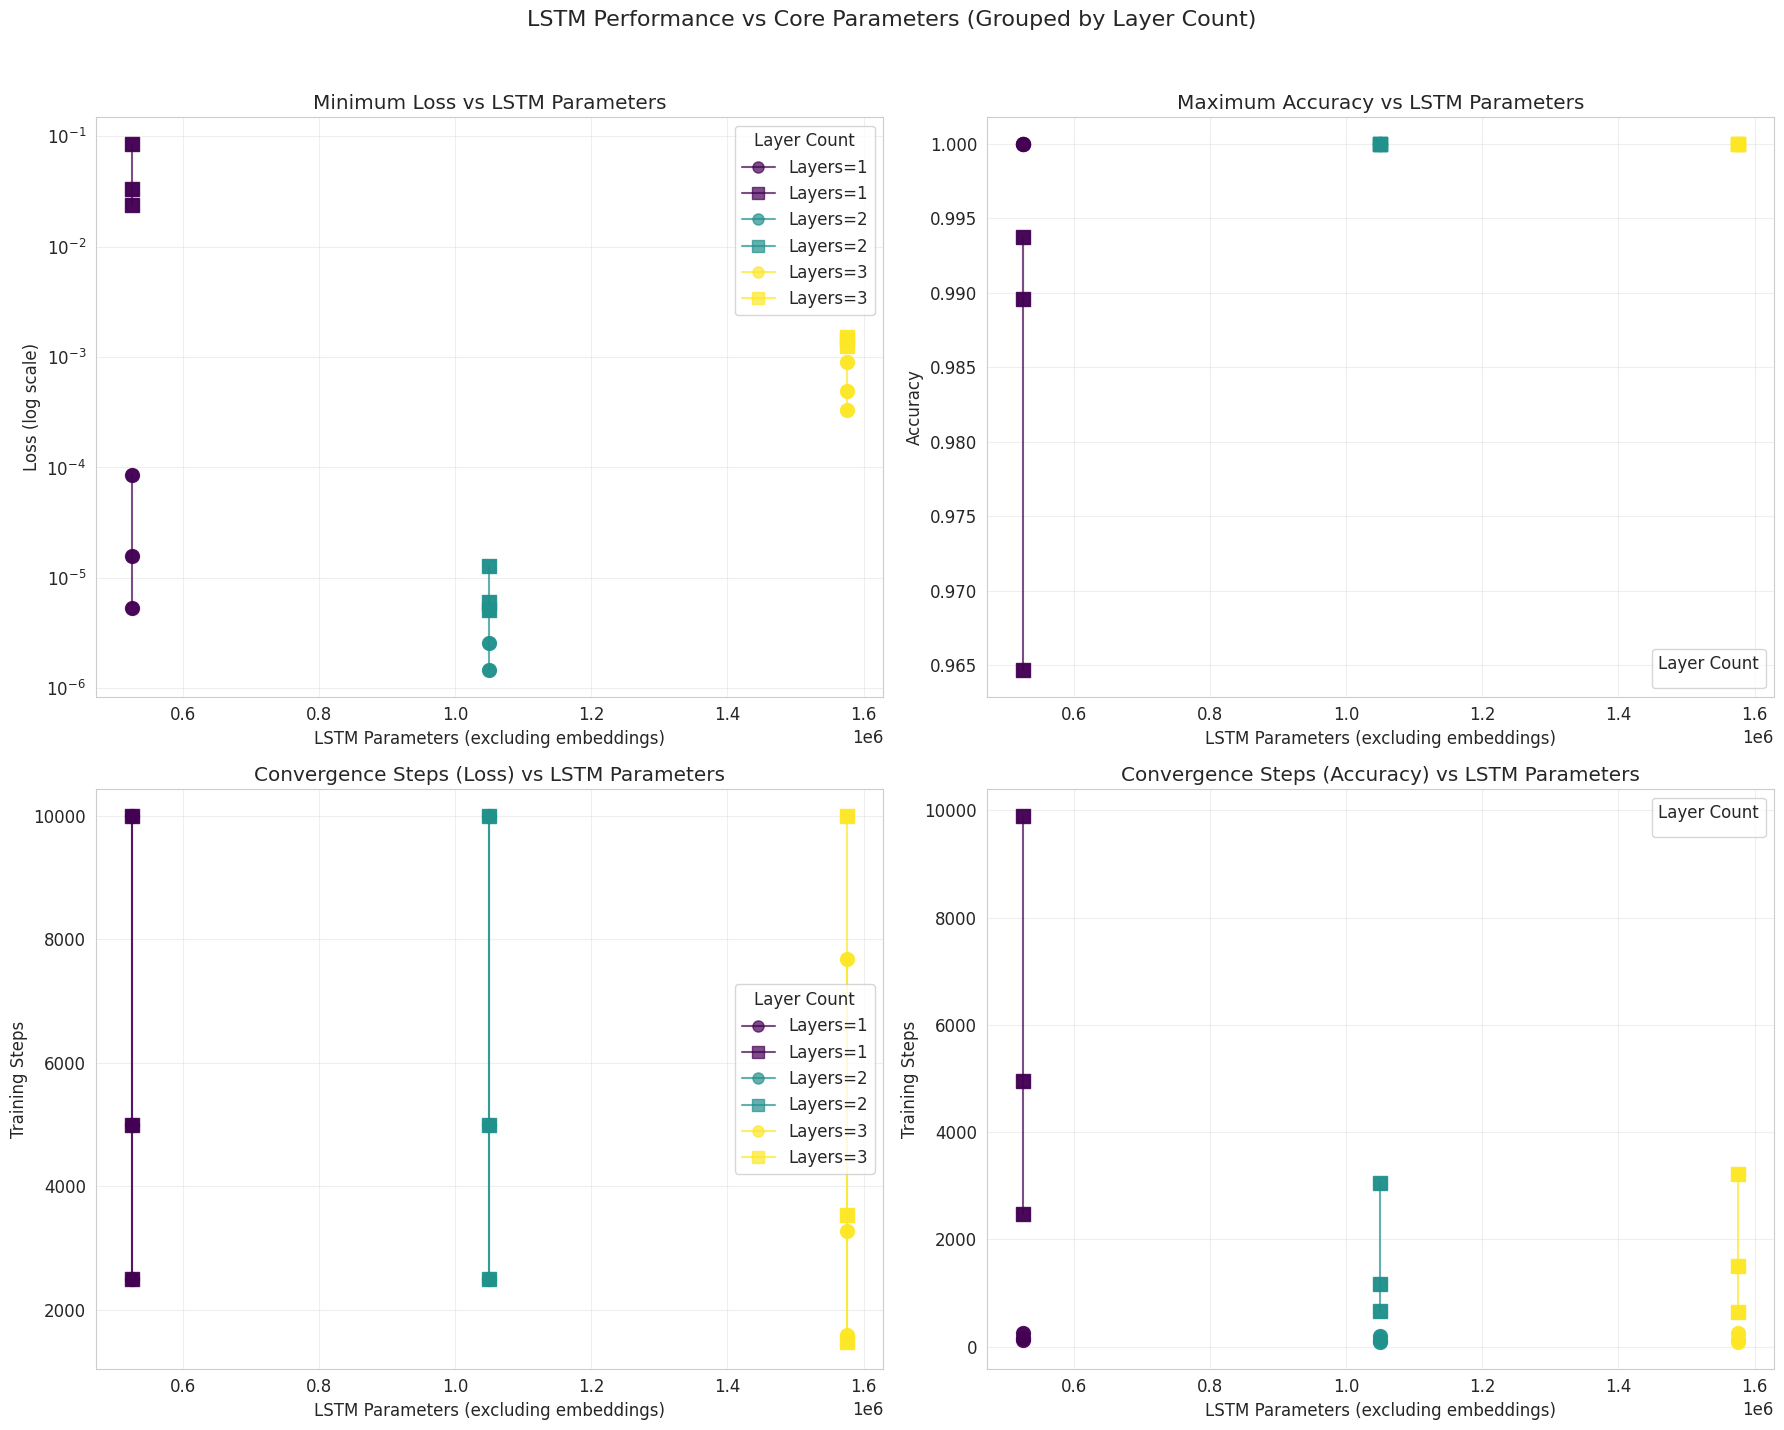


LSTM Parameters Statistics by Layer Count:
       count       mean  std        min        25%        50%        75%  \
Layer                                                                      
1        3.0   525312.0  0.0   525312.0   525312.0   525312.0   525312.0   
2        3.0  1050624.0  0.0  1050624.0  1050624.0  1050624.0  1050624.0   
3        3.0  1575936.0  0.0  1575936.0  1575936.0  1575936.0  1575936.0   

             max  
Layer             
1       525312.0  
2      1050624.0  
3      1575936.0  


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def calculate_lstm_params(row, hidden_size=256):
    """Calculate LSTM parameters excluding embeddings"""
    # Parameters per LSTM layer:
    # 4 * [(embed_dim + hidden_size) * hidden_size + hidden_size]
    # Assuming embed_dim = hidden_size (common practice)
    params_per_layer = 4 * ((hidden_size + hidden_size) * hidden_size + hidden_size)

    # Total parameters (excluding embeddings)
    return row['Layer'] * params_per_layer

def plot_metrics_vs_lstm_parameters(avg_metrics):
    """Plot metrics vs LSTM parameters with lines connecting same layer counts"""

    # Calculate LSTM-only parameters (excluding embeddings)
    avg_metrics['LSTM_Params'] = avg_metrics.apply(calculate_lstm_params, axis=1)

    # Create figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('LSTM Performance vs Core Parameters (Grouped by Layer Count)',
                fontsize=16, y=1.02)

    # Get unique layer counts and create color map
    unique_layers = avg_metrics['Layer'].unique()
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_layers)))
    layer_colors = dict(zip(unique_layers, colors))

    # Define metrics for each subplot
    plot_config = [
        # Top-left: Loss metrics
        {'ax': axs[0,0],
         'y_metrics': [('Min_Train_Loss', 'Training Loss', 'o'),
                       ('Min_Val_Loss', 'Validation Loss', 's')],
         'yscale': 'log',
         'title': 'Minimum Loss vs LSTM Parameters',
         'ylabel': 'Loss (log scale)'},

        # Top-right: Accuracy metrics
        {'ax': axs[0,1],
         'y_metrics': [('Max_Train_Acc', 'Training Accuracy', 'o'),
                       ('Max_Val_Acc', 'Validation Accuracy', 's')],
         'yscale': 'linear',
         'title': 'Maximum Accuracy vs LSTM Parameters',
         'ylabel': 'Accuracy'},

        # Bottom-left: Steps to min loss
        {'ax': axs[1,0],
         'y_metrics': [('Steps_To_Min_Train_Loss', 'Steps to Min Train Loss', 'o'),
                       ('Steps_To_Min_Val_Loss', 'Steps to Min Val Loss', 's')],
         'yscale': 'linear',
         'title': 'Convergence Steps (Loss) vs LSTM Parameters',
         'ylabel': 'Training Steps'},

        # Bottom-right: Steps to max accuracy
        {'ax': axs[1,1],
         'y_metrics': [('Steps_To_Max_Train_Acc', 'Steps to Max Train Acc', 'o'),
                       ('Steps_To_Max_Val_Acc', 'Steps to Max Val Acc', 's')],
         'yscale': 'linear',
         'title': 'Convergence Steps (Accuracy) vs LSTM Parameters',
         'ylabel': 'Training Steps'}
    ]

    # Plot each subplot
    for config in plot_config:
        ax = config['ax']

        # First plot all points with layer grouping
        for layer in unique_layers:
            layer_data = avg_metrics[avg_metrics['Layer'] == layer].sort_values('LSTM_Params')

            for y_metric, label, marker in config['y_metrics']:
                # Only add label once per layer to avoid duplicate legend entries
                label = f'Layers={layer}' if y_metric.endswith('Loss') else None

                ax.plot(layer_data['LSTM_Params'], layer_data[y_metric],
                       color=layer_colors[layer], marker=marker, markersize=8,
                       linestyle='-', alpha=0.7, label=label)

                ax.scatter(layer_data['LSTM_Params'], layer_data[y_metric],
                          color=layer_colors[layer], marker=marker, s=100,
                          alpha=0.9)

        ax.set_xlabel('LSTM Parameters (excluding embeddings)')
        ax.set_ylabel(config['ylabel'])
        ax.set_title(config['title'])
        ax.set_yscale(config['yscale'])
        ax.legend(title='Layer Count')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Show parameter statistics by layer
    print("\nLSTM Parameters Statistics by Layer Count:")
    print(avg_metrics.groupby('Layer')['LSTM_Params'].describe())

# Generate the plots
plot_metrics_vs_lstm_parameters(avg_metrics)

## GPT


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

# Base directory containing the logs
base_dir = "/content/gdrive/MyDrive/Colab Notebooks/IFT6135_W25_A2_release/logs/gpt"

# Configuration parameters
layers = [1, 2, 3]  # Process all layers
batch_sizes = [64, 128, 256]  # 2^6=64, 2^7=128, 2^8=256

# Initialize dictionaries to store paths and metrics
file_paths = defaultdict(list)
param_file_paths = defaultdict(list)
raw_metrics = defaultdict(dict)
summary_metrics = []

def to_np(x):
    """Convert torch.Tensors or lists to numpy arrays"""
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    return x

def read_num_params(file_path):
    """Read number of parameters from a text file"""
    try:
        with open(file_path, 'r') as f:
            content = f.read().strip()
            # Extract the number from the file
            # Assuming the file contains a single number or a line like "Number of parameters: 12345"
            try:
                if "parameters" in content.lower():
                    # Try to extract the number from text like "Number of parameters: 12345"
                    num_params = int(content.split(":")[-1].strip())
                else:
                    # Try to convert the content directly to an integer
                    num_params = int(content)
                return num_params
            except ValueError:
                print(f"Could not parse number of parameters from: {content}")
                return None
    except Exception as e:
        print(f"Error reading parameter file {file_path}: {e}")
        return None

# Collect all the log file paths and parameter file paths
for layer in layers:
    for b in batch_sizes:
        # Construct the path pattern
        dir_path = os.path.join(base_dir, f"layer_{layer}", f"b={b}")

        # Find all subdirectories (like '0/', '1/', etc.)
        try:
            subdirs = [d for d in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, d))]
        except FileNotFoundError:
            print(f"Directory not found: {dir_path}")
            continue

        for subdir in subdirs:
            # Try multiple possible filename patterns for model metrics
            possible_files = [
                os.path.join(dir_path, subdir, f"B={b}.pth"),
                os.path.join(dir_path, subdir, f"B={b}_L={layer}.pth"),
                os.path.join(dir_path, subdir, f"b={b}.pth")
            ]

            # Path for parameter file
            param_file = os.path.join(dir_path, subdir, "num_params.txt")

            for file_path in possible_files:
                if os.path.exists(file_path):
                    key = (layer, b)
                    file_paths[key].append(file_path)

                    # Also check if parameter file exists for this run
                    if os.path.exists(param_file):
                        param_file_paths[key].append(param_file)
                    else:
                        # If parameter file doesn't exist, add None to maintain correspondence
                        param_file_paths[key].append(None)
                        print(f"Parameter file not found for: {file_path}")

                    break  # Use the first valid file found

# Extract metrics for all found files
for (layer, b), paths in file_paths.items():
    param_paths = param_file_paths.get((layer, b), [None] * len(paths))

    for path_idx, (path, param_path) in enumerate(zip(paths, param_paths)):
        try:
            data = torch.load(path, map_location=torch.device('cpu'))

            # Verify the expected keys are present
            if not all(k in data for k in ['train', 'test', 'steps_epoch']):
                print(f"Unexpected data format in {path}")
                continue

            # Convert all metrics to numpy arrays
            train_loss = to_np(data['train']['loss'])
            val_loss = to_np(data['test']['loss'])
            train_acc = to_np(data['train']['accuracy'])
            val_acc = to_np(data['test']['accuracy'])
            steps = to_np(list(data['steps_epoch'].values()))

            # Make sure we don't have more steps than data points
            min_len = min(len(train_loss), len(val_loss), len(train_acc), len(val_acc), len(steps))
            train_loss = train_loss[:min_len]
            val_loss = val_loss[:min_len]
            train_acc = train_acc[:min_len]
            val_acc = val_acc[:min_len]
            steps = steps[:min_len]

            # Find minimum loss and corresponding step
            train_min_loss_idx = np.argmin(train_loss)
            val_min_loss_idx = np.argmin(val_loss)

            # Find maximum accuracy and corresponding step
            train_max_acc_idx = np.argmax(train_acc)
            val_max_acc_idx = np.argmax(val_acc)

            # Read the number of parameters if the file exists
            num_params = None
            if param_path:
                num_params = read_num_params(param_path)

            # Collect metrics in a structured format
            run_metrics = {
                'Layer': layer,
                'Batch_Size': b,
                'Run': path_idx + 1,
                'Num_Parameters': num_params,

                # Minimum loss values
                'Min_Train_Loss': train_loss[train_min_loss_idx],
                'Min_Val_Loss': val_loss[val_min_loss_idx],

                # Maximum accuracy values
                'Max_Train_Acc': train_acc[train_max_acc_idx],
                'Max_Val_Acc': val_acc[val_max_acc_idx],

                # Steps to reach optimal values
                'Steps_To_Min_Train_Loss': steps[train_min_loss_idx],
                'Steps_To_Min_Val_Loss': steps[val_min_loss_idx],
                'Steps_To_Max_Train_Acc': steps[train_max_acc_idx],
                'Steps_To_Max_Val_Acc': steps[val_max_acc_idx]
            }

            summary_metrics.append(run_metrics)

            # Store raw metrics for possible further analysis
            key = (layer, b, path_idx)
            raw_metrics[key] = {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'steps': steps,
                'num_params': num_params
            }

        except Exception as e:
            print(f"Error processing {path}: {e}")

# Convert to DataFrame for easier analysis
metrics_df = pd.DataFrame(summary_metrics)

# Calculate average metrics across runs for each layer and batch size
avg_metrics = metrics_df.groupby(['Layer', 'Batch_Size']).mean().reset_index()

# Print summary table
print("\nSummary Metrics by Layer and Batch Size (Averaged across runs):")
print(avg_metrics.to_string(index=False))

# Export to CSV if needed
metrics_df.to_csv('lstm_metrics_detailed.csv', index=False)
avg_metrics.to_csv('lstm_metrics_summary.csv', index=False)

# Create a pivot table for easier comparison of parameters
pivot_params = pd.pivot_table(
    metrics_df,
    values=['Num_Parameters'],
    index='Layer',
    columns='Batch_Size',
    aggfunc='mean'  # Average if there are multiple runs with same config
)

print("\nNumber of Parameters (Layer vs Batch Size):")
print(pivot_params)

# Create additional pivot tables for metrics
pivot_min_loss = pd.pivot_table(
    avg_metrics,
    values=['Min_Train_Loss', 'Min_Val_Loss'],
    index='Layer',
    columns='Batch_Size'
)

pivot_max_acc = pd.pivot_table(
    avg_metrics,
    values=['Max_Train_Acc', 'Max_Val_Acc'],
    index='Layer',
    columns='Batch_Size'
)

pivot_time_to_min_loss = pd.pivot_table(
    avg_metrics,
    values=['Steps_To_Min_Train_Loss', 'Steps_To_Min_Val_Loss'],
    index='Layer',
    columns='Batch_Size'
)

pivot_time_to_max_acc = pd.pivot_table(
    avg_metrics,
    values=['Steps_To_Max_Train_Acc', 'Steps_To_Max_Val_Acc'],
    index='Layer',
    columns='Batch_Size'
)

print("\nMinimum Loss (Layer vs Batch Size):")
print(pivot_min_loss)

print("\nMaximum Accuracy (Layer vs Batch Size):")
print(pivot_max_acc)

print("\nSteps to Minimum Loss (Layer vs Batch Size):")
print(pivot_time_to_min_loss)

print("\nSteps to Maximum Accuracy (Layer vs Batch Size):")
print(pivot_time_to_max_acc)

# Create analysis based on number of parameters
if not metrics_df['Num_Parameters'].isna().all():
    # Group by parameter ranges or just sort by parameters
    metrics_df['Param_Range'] = pd.cut(metrics_df['Num_Parameters'], bins=5)

    # Analyze metrics by parameter count
    param_analysis = metrics_df.groupby('Param_Range').mean()[
        ['Min_Train_Loss', 'Min_Val_Loss', 'Max_Train_Acc', 'Max_Val_Acc',
         'Steps_To_Min_Train_Loss', 'Steps_To_Min_Val_Loss',
         'Steps_To_Max_Train_Acc', 'Steps_To_Max_Val_Acc']
    ]

    print("\nMetrics by Parameter Range:")
    print(param_analysis)

    # You can also create a scatter plot of parameters vs metrics if using in a notebook
    # plt.scatter(metrics_df['Num_Parameters'], metrics_df['Min_Val_Loss'])
    # plt.xlabel('Number of Parameters')
    # plt.ylabel('Minimum Validation Loss')
    # plt.title('Model Complexity vs. Performance')
    # plt.show()


Summary Metrics by Layer and Batch Size (Averaged across runs):
 Layer  Batch_Size  Run  Num_Parameters  Min_Train_Loss  Min_Val_Loss  Max_Train_Acc  Max_Val_Acc  Steps_To_Min_Train_Loss  Steps_To_Min_Val_Loss  Steps_To_Max_Train_Acc  Steps_To_Max_Val_Acc
     1          64  1.5        206884.0        0.000618      0.001161            1.0     1.000000                   2181.5                 1900.5                    75.5                 800.5
     1         128  1.5        206884.0        0.000430      0.001178            1.0     1.000000                   3937.5                 3650.0                   125.0                2450.0
     1         256  1.5        206884.0        0.000322      0.155345            1.0     0.905405                   7600.0                 8375.5                   225.0                7925.0
     2          64  1.5        404516.0        0.002031      0.004116            1.0     1.000000                   1350.5                 1863.0                    31

<ipython-input-14-4788a3380056>:241: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  param_analysis = metrics_df.groupby('Param_Range').mean()[


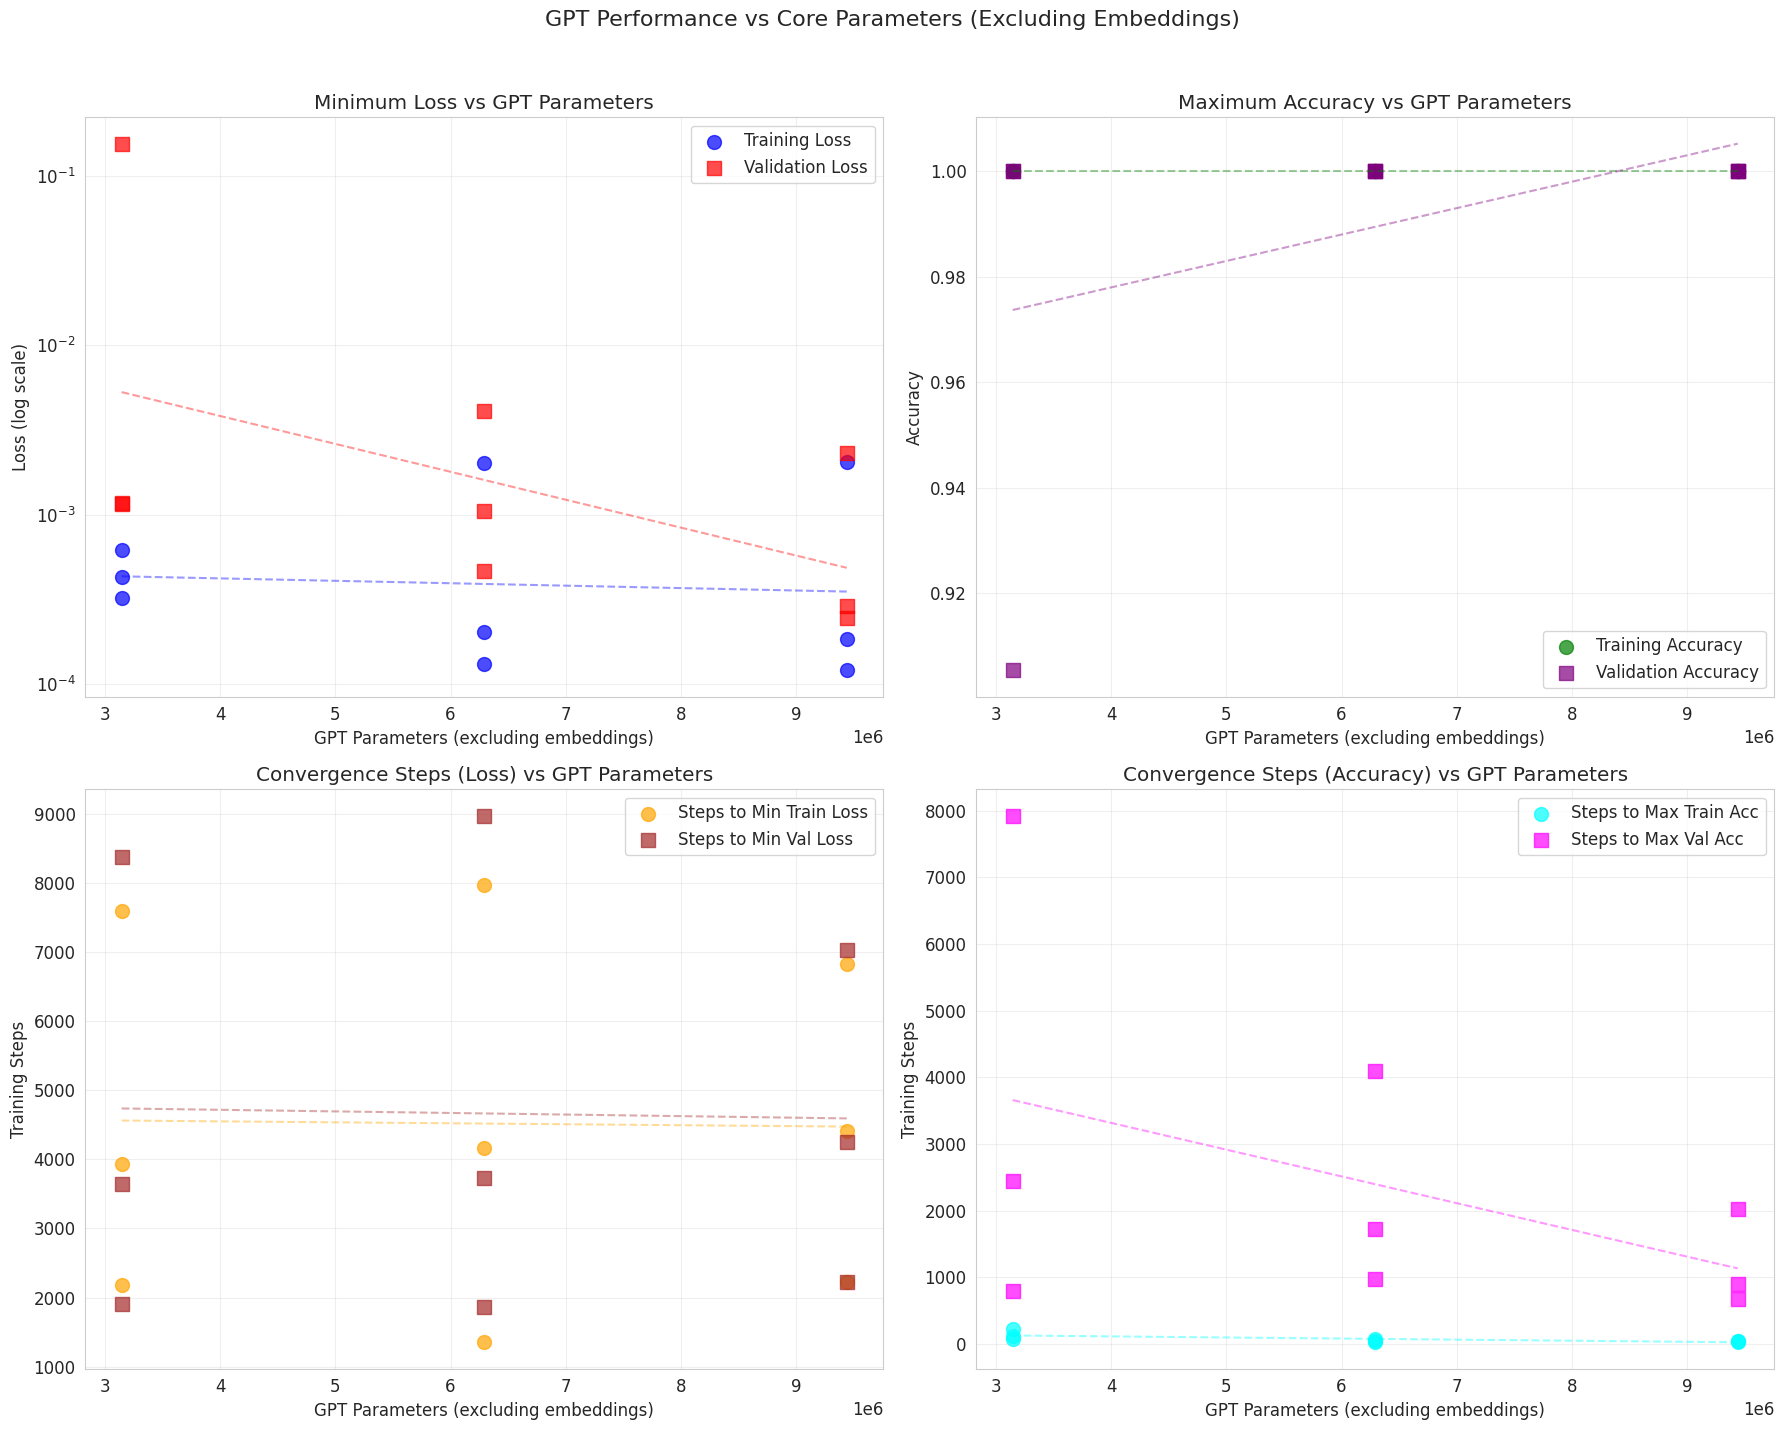


GPT Parameters (excluding embeddings) Statistics:
count    9.000000e+00
mean     6.291456e+06
std      2.724280e+06
min      3.145728e+06
25%      3.145728e+06
50%      6.291456e+06
75%      9.437184e+06
max      9.437184e+06
Name: GPT_Params, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def calculate_gpt_params(row, d_model=512):
    """Calculate GPT parameters excluding embeddings and positional encodings"""
    # Parameters per transformer layer:
    # 1. Attention layers: 4*d_model^2 (Q,K,V projections + output projection)
    # 2. Feed-forward layers: 2*4*d_model^2 (assuming intermediate size is 4*d_model)
    # 3. Layer norms: negligible (2*d_model per layer)
    params_per_layer = 12 * d_model**2

    # Total parameters (excluding embeddings)
    return row['Layer'] * params_per_layer

def plot_metrics_vs_gpt_parameters(avg_metrics):
    """Plot metrics vs only GPT parameters (excluding embeddings)"""

    # Calculate GPT-only parameters (excluding embeddings)
    avg_metrics['GPT_Params'] = avg_metrics.apply(calculate_gpt_params, axis=1)

    # Create figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('GPT Performance vs Core Parameters (Excluding Embeddings)', fontsize=16, y=1.02)

    # Define metrics for each subplot
    plot_config = [
        # Top-left: Loss metrics
        {'ax': axs[0,0],
         'y_metrics': [('Min_Train_Loss', 'Training Loss', 'blue', 'o'),
                       ('Min_Val_Loss', 'Validation Loss', 'red', 's')],
         'yscale': 'log',
         'title': 'Minimum Loss vs GPT Parameters',
         'ylabel': 'Loss (log scale)'},

        # Top-right: Accuracy metrics
        {'ax': axs[0,1],
         'y_metrics': [('Max_Train_Acc', 'Training Accuracy', 'green', 'o'),
                       ('Max_Val_Acc', 'Validation Accuracy', 'purple', 's')],
         'yscale': 'linear',
         'title': 'Maximum Accuracy vs GPT Parameters',
         'ylabel': 'Accuracy'},

        # Bottom-left: Steps to min loss
        {'ax': axs[1,0],
         'y_metrics': [('Steps_To_Min_Train_Loss', 'Steps to Min Train Loss', 'orange', 'o'),
                       ('Steps_To_Min_Val_Loss', 'Steps to Min Val Loss', 'brown', 's')],
         'yscale': 'linear',
         'title': 'Convergence Steps (Loss) vs GPT Parameters',
         'ylabel': 'Training Steps'},

        # Bottom-right: Steps to max accuracy
        {'ax': axs[1,1],
         'y_metrics': [('Steps_To_Max_Train_Acc', 'Steps to Max Train Acc', 'cyan', 'o'),
                       ('Steps_To_Max_Val_Acc', 'Steps to Max Val Acc', 'magenta', 's')],
         'yscale': 'linear',
         'title': 'Convergence Steps (Accuracy) vs GPT Parameters',
         'ylabel': 'Training Steps'}
    ]

    # Plot each subplot
    for config in plot_config:
        ax = config['ax']
        for y_metric, label, color, marker in config['y_metrics']:
            ax.scatter(avg_metrics['GPT_Params'], avg_metrics[y_metric],
                      color=color, label=label, marker=marker, s=100, alpha=0.7)

            # Add trend line
            if len(avg_metrics) > 1:
                if config['yscale'] == 'log':
                    z = np.polyfit(avg_metrics['GPT_Params'], np.log(avg_metrics[y_metric]), 1)
                    p = np.poly1d(z)
                    trend = np.exp(p(avg_metrics['GPT_Params']))
                else:
                    z = np.polyfit(avg_metrics['GPT_Params'], avg_metrics[y_metric], 1)
                    p = np.poly1d(z)
                    trend = p(avg_metrics['GPT_Params'])

                ax.plot(avg_metrics['GPT_Params'], trend,
                       color=color, linestyle='--', alpha=0.4)

        ax.set_xlabel('GPT Parameters (excluding embeddings)')
        ax.set_ylabel(config['ylabel'])
        ax.set_title(config['title'])
        ax.set_yscale(config['yscale'])
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Show parameter statistics
    print("\nGPT Parameters (excluding embeddings) Statistics:")
    print(avg_metrics['GPT_Params'].describe())

# Generate the plots
plot_metrics_vs_gpt_parameters(avg_metrics)